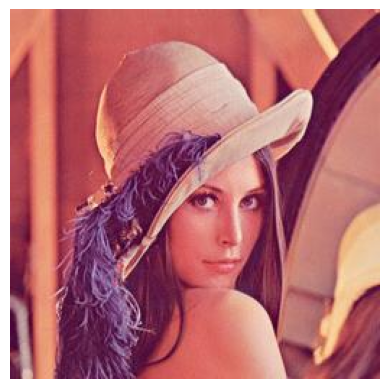

0101110100100011101111101101001011001001000111011111011010111110001011001110010100100010101111101011001010010101101110100010000010010010001101101111110001100101111011110110111100001011011000101110111110110100100011100010011011111011110010010101101000111110001001101111101111001100110010010011110111111000101001001101011111100010100100110101111110001011011001001101011111100110100100110101111110011011011001001101011111100010000011001001101011111100010100100110101111110011010010011010111111001101001001101011111100010100100110101111110001011001001001101011111100010001001011111100100010001100101111101101011000100100011110001100100110010011111011011111011010010110000011111001000111011111010110010110100000100100010101111101011001011001001000101011111011110010110010010001010111110101101111110111111011110011101110111000010011110111101100100100001110110010111101110110010111110010111111110010010111010111101101110000111101101000110010010001111100100011011011001011110110011011000100101101011101110010

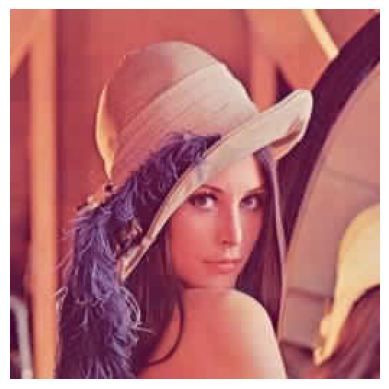

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from os import path
import cv2

zigzagPattern = [
     0,  1,  8, 16,  9,  2,  3, 10,
    17, 24, 32, 25, 18, 11,  4,  5,
    12, 19, 26, 33, 40, 48, 41, 34,
    27, 20, 13,  6,  7, 14, 21, 28,
    35, 42, 49, 56, 57, 50, 43, 36,
    29, 22, 15, 23, 30, 37, 44, 51,
    58, 59, 52, 45, 38, 31, 39, 46,
    53, 60, 61, 54, 47, 55, 62, 63
]

class JPEG:
    def __init__(self,name,subSampling=[4,2,2],qualityFactor=1):
        self.img = mpimg.imread(name).tolist()
        self.shape = [len(self.img),len(self.img[0])]
        if type(self.img[0][0]) == int:
            self.img = [[[self.img[i][j] for k in range(3)] for j in range(len(self.img[0]))] for i in range(len(self.img))]

        self.subSampling = subSampling
        self.qualityFactor = qualityFactor
        self.paddedShape = None
        self.paddedResolution = None
        self.huffmanCode = None
        self.huffmanLength = None
        self.Y_table = [[16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]]

        self.C_table = [[17, 18, 24, 47, 24, 40, 51, 61],
                        [18, 21, 26, 66, 99, 99, 99, 99],
                        [24, 26, 56, 99, 99, 99, 99, 99],
                        [47, 66, 99, 99, 99, 99, 99, 99],
                        [99, 99, 99, 99, 99, 99, 99, 99],
                        [99, 99, 99, 99, 99, 99, 99, 99],
                        [99, 99, 99, 99, 99, 99, 99, 99],
                        [99, 99, 99, 99, 99, 99, 99, 99]]

    def compress_img(self):

        show_img(self.img)

        self.img = padding(self.img)
        self.paddedShape = [len(self.img)//8, len(self.img[0])//8]

        self.img = rgb2ycbcr(self.img)

        C_subSampling(self.img,self.subSampling)

        self.img = sliceImage(self.img)

        self.img = dctTransform(self.img)

        self.img = quantize(self.img,self.Y_table,self.C_table)

        self.img = zig_zag(self.img)

        self.huffmanCode,self.huffmanLength = huffmanCode(self.img)

        print(self.huffmanLength)

    def decompress_img(self):

        self.img = huffmanDecode(self.huffmanCode,self.huffmanLength)

        self.img = reverse_zig_zag(self.img,self.paddedShape)

        self.img = quantize(self.img,self.Y_table,self.C_table,inverse=True)

        self.img = dctTransform(self.img,inverse= True)

        self.img = combineBlocks(self.img,self.paddedShape)

        self.img = ycbcr2rgb(self.img)

        self.img = remove_padding(self.img,self.shape)

        show_img(self.img)

def show_img(img, components=False):
    if components:
        f, ax = plt.subplots(1, 4)
        ax[0].imshow(img[:, :, 0], cmap='gray')
        ax[0].axis('off')

        ax[1].imshow(img[:, :, 1], cmap='gray')
        ax[1].axis('off')

        ax[2].imshow(img[:, :, 2], cmap='gray')
        ax[2].axis('off')

        ax[3].imshow(img, cmap='gray')
        ax[3].axis('off')
    else:
        plt.imshow(img)
        plt.axis('off')
        plt.imsave('compressed.jpg', img)
    plt.show()


def padding(img):
    block = 8
    rowPad = block - (len(img)%block)
    colPad = block - (len(img[0])%block)
    if rowPad == block:
        rowPad = 0
    if colPad == block:
        colPad = 0
    out = [[[0 for k in range(3)] for j in range(colPad + len(img[0]))] for i in range(rowPad + len(img))]
    for i in range(len(out)):
        for j in range(len(out[0])):
            for k in range(len(out[0][0])):
                if i>=len(img):
                    i1 = len(img)-1
                else:
                    i1 = i
                if j >= len(img[0]):
                    j1 = len(img[0])-1
                else:
                    j1 = j
                out[i][j][k] = img[i1][j1][k]
    return out

def remove_padding(img,shape):
    out = [[[img[i][j][k] for k in range(len(img[0][0]))] for j in range(shape[1])] for i in range(shape[0])]
    return out

def rgb2ycbcr(img):
    xform = [[0.299, 0.587, 0.114], [-0.168736, -0.331264, 0.500], [0.500, -0.418688, -0.081312]]
    out = [[[0 for k in range(len(img[0][0]))] for j in range(len(img[0]))] for i in range(len(img))]
    for i in range(len(img)):
        for j in range(len(img[0])):
            out[i][j][0] = int(abs(xform[0][0]*img[i][j][0]+xform[0][1]*img[i][j][1]+xform[0][2]*img[i][j][2]))%256
            out[i][j][1] = int(abs(xform[1][0]*img[i][j][0]+xform[1][1]*img[i][j][1]+xform[1][2]*img[i][j][2]+128))%256
            out[i][j][2] = int(abs(xform[2][0]*img[i][j][0]+xform[2][1]*img[i][j][1]+xform[2][2]*img[i][j][2]+128))%256
    return out

def ycbcr2rgb(img):
    xform = [[1, 0, 1.402], [1, -0.34414, -0.71414], [1, 1.772, 0]]
    # print((img[0][0][0]))
    # print(np.array(img).shape)
    img = [[[img[i][j][k]+128 for k in range(len(img[0][0]))] for j in range(len(img[0]))] for i in range(len(img))]
    out = [[[0 for k in range(3)] for j in range(len(img[0]))] for i in range(len(img))]
    for i in range(len(img)):
        for j in range(len(img[0])):
            out[i][j][0] = int(xform[0][0]*img[i][j][0]+xform[0][1]*(img[i][j][1]-128)+xform[0][2]*(img[i][j][2]-128))
            out[i][j][1] = int(xform[1][0]*img[i][j][0]+xform[1][1]*(img[i][j][1]-128)+xform[1][2]*(img[i][j][2]-128))
            out[i][j][2] = int(xform[2][0]*img[i][j][0]+xform[2][1]*(img[i][j][1]-128)+xform[2][2]*(img[i][j][2]-128))
    return out

def C_subSampling(img,subSampling):
    for row in range(0,len(img),2):
        for col in range(0,len(img[0]),4):

            MCU = [img[row][col:col+4], img[row+1][col:col+4]]
            MCU_Cb = [0 for i in range(4)]
            MCU_Cr = [0 for i in range(4)]

            if subSampling == [4,2,2]:
                MCU_Cb[0]=MCU[0][0][1]+MCU[0][1][1]
                MCU_Cb[1]=MCU[0][2][1]+MCU[0][3][1]
                MCU_Cb[2]=MCU[1][0][1]+MCU[1][1][1]
                MCU_Cb[3]=MCU[1][2][1]+MCU[1][3][1]

                MCU_Cr[0]=MCU[0][0][2]+MCU[0][1][2]
                MCU_Cr[1]=MCU[0][2][2]+MCU[0][3][2]
                MCU_Cr[2]=MCU[1][0][2]+MCU[1][1][2]
                MCU_Cr[3]=MCU[1][2][2]+MCU[1][3][2]

                index = 0
                for x in range(2):
                    for y in range(4):
                        if x == 0 and y == 2:
                            index += 1
                        elif x == 1 and y == 0:
                            index += 1
                        elif x == 1 and y ==2:
                            index+=1
                        img[row+x][col+y][1] = MCU_Cb[index]//2
                        img[row+x][col+y][2] = MCU_Cr[index]//2

def sliceImage(img):
    rowCounter = len(img)
    colCounter = len(img[0])
    out = [[None for i in range(colCounter//8)] for j in range(rowCounter//8)]
    counterRow = -1
    for row in range(0,rowCounter,8):
        counterRow+=1
        counterCol = -1
        for col in range(0,colCounter,8):
            counterCol+=1
            out[counterRow][counterCol] = [[[img[row+i][col+j][k]-128 for k in range(3)]for j in range(8)]for i in range(8)]
    return out

def combineBlocks(out,shape):
    rowCounter = shape[0]*8
    colCounter = shape[1]*8
    img = [[[0 for k in range(3)] for j in range(colCounter)] for i in range(rowCounter)]
    for i in range(len(out)):
        for j in range(len(out[0])):
            for k in range(3):
                for x in range(8):
                    for y in range(8):
                        img[i*8+x][j*8+y][k] = out[i][j][x][y][k]
    return img

def transpose(img):

    img = [[[img[j][i][k] for k in range(len(img[0][0]))] for j in range(len(img[0]))] for i in range(len(img))]

    return img

def fdct1D(f):
    C = []
    for i in range(8):
        C.append(math.cos(i*math.pi/16))

    D = [f[0]-f[7], f[1]-f[6],f[2]-f[5],f[3]-f[4],(f[0]+f[7])-(f[3]+f[4]),(f[1]+f[6])-(f[2]+f[5])]

    S = [f[0]+f[7], f[1]+f[6],f[2]+f[5],f[3]+f[4],(f[0]+f[7])+(f[3]+f[4]),(f[1]+f[6])+(f[2]+f[5])]

    F = []
    F.append(C[4]*(S[4]+S[5])/2)
    F.append((C[1]*D[0]+C[3]*D[1]+C[5]*D[2]+C[7]*D[3])/2)
    F.append((C[2]*D[4]-C[6]*D[5])/2)
    F.append((C[3]*D[0]-C[7]*D[1]-C[1]*D[2]-C[5]*D[3])/2)
    F.append(C[4]*(S[4]-S[5])/2)
    F.append((C[5]*D[0]-C[1]*D[1]+C[7]*D[2]+C[3]*D[3])/2)
    F.append((C[6]*D[4]-C[6]*D[5])/2)
    F.append((C[7]*D[0]-C[5]*D[1]+C[3]*D[2]-C[1]*D[3])/2)

    return F

def fidct1D(F):

    C = []
    for i in range(8):
        C.append(math.cos((i)*math.pi/16)/math.sqrt(4))

    # print(C)

    a = C[1]
    b = C[2]
    c = C[3]
    f = C[5]
    d = C[6]
    e = C[7]

    B = [(F[0]+F[4])/math.sqrt(8), (F[0]-F[4])/math.sqrt(8)]

    C = [b*F[2] + d*F[6], d*F[2]-b*F[6]]

    D = [(e*F[7]+f*F[5]+a*F[1]+c*F[3]),(f*F[7]+a*F[5]-c*F[1]+e*F[3]),(-a*F[7]+c*F[5]+e*F[1]-f*F[3]),(c*F[7]+e*F[5]+f*F[1]-a*F[3])]

    S = [0 for i in range(8)]
    S[0]=(B[0]+C[0]+D[0])
    S[6]=(B[1]+C[1]+D[1])
    S[3]=(B[0]-C[0]+D[2])
    S[2]=(B[1]-C[1]+D[3])
    S[7]=(B[0]+C[0]-D[0])
    S[1]=(B[1]+C[1]-D[1])
    S[4]=(B[0]-C[0]-D[2])
    S[5]=(B[1]-C[1]-D[3])

    return S

def fdct2D(img):
    out = []
    for i in range(8):
        out0 = [img[i][j][0] for j in range(8)]
        out1 = [img[i][j][1] for j in range(8)]
        out2 = [img[i][j][2] for j in range(8)]
        out0 = fdct1D(out0)
        out1 = fdct1D(out1)
        out2 = fdct1D(out2)
        out.append([[out0[j],out1[j],out2[j]] for j in range(8)])
    img = transpose(out)
    out = []
    for i in range(8):
        out0 = [img[i][j][0] for j in range(8)]
        out1 = [img[i][j][1] for j in range(8)]
        out2 = [img[i][j][2] for j in range(8)]
        out0 = fdct1D(out0)
        out1 = fdct1D(out1)
        out2 = fdct1D(out2)
        out.append([[out0[j],out1[j],out2[j]] for j in range(8)])
    out = transpose(out)
    return out

def fidct2D(img):
    out = []
    for i in range(8):
        out0 = [img[i][j][0] for j in range(8)]
        out1 = [img[i][j][1] for j in range(8)]
        out2 = [img[i][j][2] for j in range(8)]
        out0 = fidct1D(out0)
        out1 = fidct1D(out1)
        out2 = fidct1D(out2)
        out.append([[out0[j],out1[j],out2[j]] for j in range(8)])
    img = transpose(out)
    out = []
    for i in range(8):
        out0 = [img[i][j][0] for j in range(8)]
        out1 = [img[i][j][1] for j in range(8)]
        out2 = [img[i][j][2] for j in range(8)]
        out0 = fidct1D(out0)
        out1 = fidct1D(out1)
        out2 = fidct1D(out2)
        out.append([[out0[j],out1[j],out2[j]] for j in range(8)])
    out = transpose(out)
    return out

def dct2D(img):
    out = []
    for u in range(8):
        out.append([])
        for v in range(8):
            out[u].append([])
            if u == 0:
                Cu = 1/math.sqrt(2)
            else:
                Cu = 1
            if v == 0:
                Cv = 1/math.sqrt(2)
            else:
                Cv = 1
            for k in range(3):
                sum = 0
                for x in range(8):
                    for y in range(8):
                        sum += img[x][y][k]*math.cos(((2.0*x + 1)*u*math.pi)/16.0)*math.cos(((2.0*y+1)*v*math.pi)/16.0)
                out[u][v].append(Cu*Cv*sum/4)
    return out

def idct2D(img):
    out = []
    for x in range(8):
        out.append([])
        for y in range(8):
            out[x].append([])
            for k in range(3):
                sum = 0
                for u in range(8):
                    for v in range(8):
                        if u == 0:
                            Cu = 1/math.sqrt(2)
                        else:
                            Cu = 1
                        if v == 0:
                            Cv = 1/math.sqrt(2)
                        else:
                            Cv = 1
                        sum += Cu*Cv*img[u][v][k]*math.cos(((2.0*x + 1)*u*math.pi)/16.0)*math.cos(((2.0*y+1)*v*math.pi)/16.0)
                out[x][y].append(sum/4)
    return out

def dctTransform(img,inverse=False):
    out = [[None for i in range(len(img[0]))] for j in range(len(img))]
    for row in range(len(img)):
        for col in range(len(img[0])):
            if inverse == False:
                out[row][col] = dct2D(img[row][col])
            else:
                out[row][col] = idct2D(img[row][col])
    return out

def quant(img,yTable,cTable,inverse=False):
    out = [[[0 for k in range(3)] for j in range(8)] for i in range(8)]
    for u in range(8):
        for v in range(8):
            if inverse==False:
                out[u][v][0] = int(img[u][v][0]/yTable[u][v])
                out[u][v][1] = int(img[u][v][1]/cTable[u][v])
                out[u][v][2] = int(img[u][v][2]/cTable[u][v])
            else:
                out[u][v][0] = int(img[u][v][0]*yTable[u][v])
                out[u][v][1] = int(img[u][v][1]*cTable[u][v])
                out[u][v][2] = int(img[u][v][2]*cTable[u][v])
    return out

def quantize(img,yTable,cTable,inverse=False):
    out = [[None for i in range(len(img[0]))] for j in range(len(img))]
    for row in range(len(img)):
        for col in range(len(img[0])):
            out[row][col] = quant(img[row][col],yTable,cTable,inverse)
    return out

def zig_zag(img):
    out = []
    for row in range(len(img)):
        for col in range(len(img[0])):
            for k in range(3):
                flat = [img[row][col][i][j][k] for i in range(8) for j in range(8)]
                new = []
                for i in zigzagPattern:
                    new.append(flat[i])
                out.append(new)
    return out

def reverse_zig_zag(out,shape):

    temp = [[0 for j in range(len(out[0]))] for i in range(len(out))]

    for idx in range(len(out)):
        for i in range(len(out[0])):
            temp[idx][zigzagPattern[i]] = out[idx][i]

    img = []
    index = 0
    for k in range(shape[0]):
        img.append([])
        for l in range(shape[1]):
            img[k].append([[[temp[index][8*i+j], temp[index+1][8*i+j], temp[index+2][8*i+j]] for j in range(8)] for i in range(8)])
            index += 3
    return img

def lowestProb(Dict):
    sortedDict = sorted(Dict.items(),key=lambda item:item[1])
    return sortedDict[0][0], sortedDict[1][0]

def huffman(Dict):
    if len(Dict) == 2:
        return dict(zip(Dict.keys(),['0','1']))
    tempDict = Dict.copy()
    val1,val2 = lowestProb(tempDict)
    popVal1,popVal2 = tempDict.pop(val1),tempDict.pop(val2)
    tempDict[(val1+"x"+val2)] = popVal1+popVal2
    combinedDict = huffman(tempDict)
    comb = combinedDict.pop((val1+"x"+val2))
    combinedDict[val1],combinedDict[val2] = comb+'0',comb+'1'
    return combinedDict

def huffmanCode(img):
    out = dict()
    out[(0,0)] = 0
    for j in img:
        zerocount = 0
        for i in j:
            if i == 0:
                zerocount+=1
            else:
                temp = (zerocount,1+int(math.log2(abs(i))))
                if temp in out:
                    out[temp] += 1
                else:
                    out[temp] = 1
                zerocount = 0
        out[(0,0)] += 1
    Dict = {str(k):float(v) for k,v in out.items()}
    convert = {str(k):k for k in out}
    # print(convert)
    out = huffman(Dict)
    final = {v:convert[k] for k,v in out.items()}
    # print(final)
    ans = ""
    for j in img:
        zerocount = 0
        for i in j:
            if i == 0:
                zerocount+=1
            else:
                temp = (zerocount,1+int(math.log2(abs(i))))
                if (i>0):
                    ans += out[str(temp)]+str(format(i,'b'))
                else :
                    temp1 = str(format(abs(i),'b'))
                    temp2 = ''
                    for i in temp1:
                        if i == '0':
                            temp2+='1'
                        else:
                            temp2+='0'
                    ans += out[str(temp)]+temp2
                zerocount = 0
        ans += out['(0, 0)']
    return final,ans

def huffmanDecode(dict,length):
    temp = ""
    out = []
    out.append([])
    idx = 0
    i = 0
    while i < (len(length)):
        temp += length[i]
        if temp in dict:
            if dict[temp] == (0, 0):
                temp2 = 64 - len(out[idx])
                for j in range(temp2):
                    out[idx].append(0)
                idx += 1
                out.append([])

            else:
                temp2 = dict[temp]
                for j in range(temp2[0]):
                    out[idx].append(0)
                temp3 = ''
                for j in range(temp2[1]):
                    try :
                        temp3 += length[i+1]
                        i+=1
                    except IndexError :
                        print(idx, len(out[idx]))
                abs = 1
                if(temp3[0] == '0'):
                    temp4 = ''
                    for j in temp3:
                        if j =='0':
                            temp4 += '1'
                        else:
                            temp4 += '0'
                    temp3 = temp4
                    abs = -1
                temp3 = reversed(temp3)
                temp4 = 0
                pow = 1
                for j in temp3:
                    temp4 += int(j)*pow
                    pow *= 2
                out[idx].append(temp4*abs)
            temp = ''
        i+=1
    out.pop()
    return out

if __name__ == '__main__':
    img = JPEG("lena.bmp")
    img.compress_img()
    print("processing decompression")
    img.decompress_img()